In [9]:
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision.transforms as transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt

import os

# Introduction

This note book will be attempting to train a GAN to generate images of dogs.

In [2]:
import zipfile

with zipfile.ZipFile('/kaggle/input/generative-dog-images/all-dogs.zip', "r") as z:
    z.extractall("/kaggle/working/dogs/")

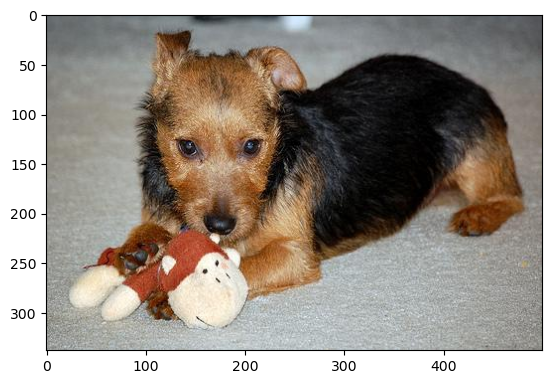

In [12]:
img_dir = '/kaggle/working/dogs/all-dogs/'
img = Image.open(img_dir + os.listdir(img_dir)[0])
plt.imshow(img)

In [19]:
num_channels = 3
img_size = 128
batch_size = 32

In [20]:
trans = transforms.Compose([transforms.Resize(img_size),
                            transforms.CenterCrop(img_size),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

dogs_dataset = datasets.ImageFolder(root='/kaggle/working/dogs/', transform=trans)
train_loader = torch.utils.data.DataLoader(dataset=dogs_dataset, batch_size=batch_size, shuffle=False)

# DCGANS

Deep Convolutional Generative Adverserial Networks are actually two networks in one, learning with eachother. The Discriminator a Convolutional Neural Network, whose job is to diffentiate between real and fake images. The Generator is Deconvolutional Neural Network, that will generate the actual images to feed to the discriminator in training (real images are also fed to discriminator at training time). The discriminator and generator are mirror images of eachother.

In [21]:
class DCGAN_D(nn.Module):
    """
    Discriminator Network. (Convolutional)
    """
    def __init__(self, num_filters):
        super(DCGAN_D, self).__init__()
        # input: 128x128 - number of channels(1) for grayscale
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=num_filters, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=num_filters)
        # input: 64x64 - num_filters
        self.conv2 = nn.Conv2d(in_channels=num_filters, out_channels=num_filters*2, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=num_filters*2)
        # input: 32x32 - num_filters * 2
        self.conv3 = nn.Conv2d(in_channels=num_filters*2, out_channels=num_filters*4, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(num_features=num_filters*4)
        # input: 16x16 - num_filters * 4
        self.conv4 = nn.Conv2d(in_channels=num_filters*4, out_channels=num_filters*8, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(num_features=num_filters*8)
        # input: 8x8 - num_filters * 8
        self.conv5 = nn.Conv2d(in_channels=num_filters*8, out_channels=num_filters*16, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(num_features=num_filters*16)
        # input: 4x4 - num_filters * 16
        self.conv6 = nn.Conv2d(in_channels=num_filters*16, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False)

    def forward(self, input):
        x = F.leaky_relu(self.bn1(self.conv1(input)), 0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.bn4(self.conv4(x)), 0.2)
        x = F.leaky_relu(self.bn5(self.conv5(x)), 0.2)
        x = F.sigmoid(self.conv6(x))
        
        return x

In [5]:
class DCGAN_G(nn.Module):
    """
    Generator Network. (Deconvolutional)
    """
    def __init__(self, latent_size, num_filters):
        super(DCGAN_G, self).__init__()
        # input: 4x4 - num_filters * 16
        self.deconv1 = nn.ConvTranspose2d(latent_size, out_channels=num_filters*16, kernel_size=4, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=num_filters*16)
        # input: 8x8 - num_filters * 8
        self.deconv2 = nn.ConvTranspose2d(in_channels=num_filters*16, out_channels=num_filters*8, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=num_filters*8)
        # input: 16x16 - num_filters * 4
        self.deconv3 = nn.ConvTranspose2d(in_channels=num_filters*8, out_channels=num_filters*4, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(num_features=num_filters*4)
        # input: 32x32 - num_filters * 2
        self.deconv4 = nn.ConvTranspose2d(in_channels=num_filters*4, out_channels=num_filters*2, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(num_features=num_filters*2)
        # input: 64x64 - num_filters
        self.deconv5 = nn.ConvTranspose2d(in_channels=num_filters*2, out_channels=num_filters, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(num_features=num_filters)
        # input: 128x128 - number of channels (1) for grayscale
        self.deconv6 = nn.ConvTranspose2d(in_channels=num_filters, out_channels=num_channels, kernel_size=4, stride=2, padding=1, bias=False)

    def forward(self, input):
        x = F.relu(self.bn1(self.deconv1(input)))
        x = F.relu(self.bn2(self.deconv2(x)))
        x = F.relu(self.bn3(self.deconv3(x)))
        x = F.relu(self.bn4(self.deconv4(x)))
        x = F.relu(self.bn5(self.deconv5(x)))
        x = F.tanh(self.deconv6(x))

        return x

In [37]:
filters, feature_space = 32, 128

device = 'cuda' if torch.cuda.is_available() else 'cpu'

netG = DCGAN_G(latent_size=feature_space, num_filters=filters).to(device)
netD = DCGAN_D(num_filters=filters).to(device)

# Training and image generation

The following method generates random latent vector space to feed to the generator. We then define the main training loop and train both networks at the same time.

In [38]:
def create_noise(b):
    """
    Create an image of random noise.
    :param b - batch size
    """
    return torch.zeros(b, feature_space, 1, 1).normal_(0, 1)

In [39]:
# Binary Cross Entropy loss
criterion = nn.BCELoss()

# Optimizers
optimizerD = optim.RMSprop(netD.parameters(), lr=1e-4)
optimizerG = optim.RMSprop(netG.parameters(), lr=1e-4)

In [40]:
def train(epochs):
    """
    Main training loop.
    """
    for epoch in range(epochs):
        x = 0
        for batch, labels in train_loader:
            netD.zero_grad()

            batch_size = batch.shape[0]
            y_real = torch.ones(batch_size)     # labels for the networks, the discriminator is training to
            y_fake = torch.zeros(batch_size)    # differentiate between real and fake images, so we label them accordingly

            batch, y_real, y_fake = Variable(batch).to(device), Variable(y_real).to(device), Variable(y_fake).to(device)
            D_output_real = netD(batch).squeeze().to(device)    # predictions of real images.
            D_real_loss = criterion(D_output_real, y_real)  # Binary Cross Entropy loss

            noise = create_noise(batch_size).to(device)
            G_output = netG(noise)

            D_output_fake = netD(G_output).squeeze().to(device)    # prediction of generated images
            D_fake_loss = criterion(D_output_fake, y_fake)  # Binary Cross Entropy loss

            D_train_loss = D_fake_loss + D_real_loss
            D_train_loss.backward()
            optimizerD.step()

            # Generator Training
            netG.zero_grad()

            noise = create_noise(batch_size)
            G_output = netG(noise.to(device))
            D_output = netD(G_output).squeeze()
            G_train_loss = criterion(D_output, y_real)
            G_train_loss.backward()
            optimizerG.step()

            if x % 50 == 0:
                print('D loss: {}\tG loss: {}\tProgress: {}/{}'.format(D_train_loss, G_train_loss, x, 
                                                                       len(train_loader)))

            x += 1

In [41]:
train(2)

D loss: 1.4057716131210327	G loss: 9.050854682922363	Progress: 0/644
D loss: 0.5615724325180054	G loss: 4.810317039489746	Progress: 50/644
D loss: 0.13585439324378967	G loss: 4.552270889282227	Progress: 100/644
D loss: 0.06396535038948059	G loss: 5.615540504455566	Progress: 150/644
D loss: 0.044498950242996216	G loss: 5.578167915344238	Progress: 200/644
D loss: 0.027998510748147964	G loss: 5.91817569732666	Progress: 250/644
D loss: 0.010396387428045273	G loss: 6.943540573120117	Progress: 300/644
D loss: 0.009349677711725235	G loss: 6.61860466003418	Progress: 350/644
D loss: 0.008269562385976315	G loss: 6.9065656661987305	Progress: 400/644
D loss: 0.004095358774065971	G loss: 7.309488296508789	Progress: 450/644
D loss: 0.001961612142622471	G loss: 7.824390411376953	Progress: 500/644
D loss: 0.03314035385847092	G loss: 4.81021785736084	Progress: 550/644
D loss: 0.02539190463721752	G loss: 6.52458381652832	Progress: 600/644
D loss: 0.025602634996175766	G loss: 9.309261322021484	Progress: 

# Results

The results are... not great. The reason I believe this isnt working well is this dataset is fairly small, GAN's usually require massive amounts of data to perform well. With this small of a dataset transfer learning would be required to get decent results. I'm also concerned my very simple preprocessing isn't enough, currently I am center cropping the images which may be cutting off important parts of the image, ideally a more advanced cropping method would be used to crop dogs faces out better.

In [42]:
def plot_images():
    fig = plt.figure(figsize=(8, 8))
    img = netG(create_noise(20).to(device))
    img = img.detach().cpu().numpy()
    arr = ((img - img.min()) * (1 / img.max() - img.min()) * 70).astype('uint8')
    for i in range(20):
        fig.add_subplot(5, 4, i + 1)
        plt.imshow(arr[i].transpose(1, 2, 0))
        plt.xticks([]),plt.yticks([])

    plt.show()

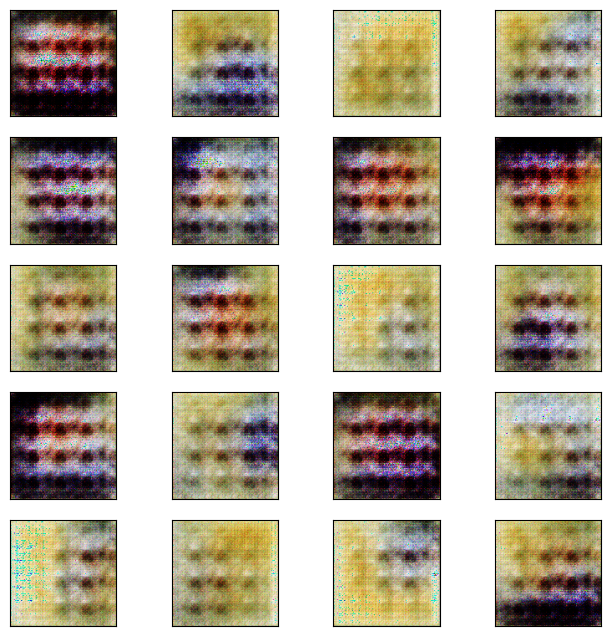

In [43]:
plot_images()